In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
image_size=256
batch_size=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",
                                                    shuffle=True,
                                                    image_size=(image_size,image_size),
                                                    batch_size=batch_size
                                                   )

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names

In [5]:
len(dataset)

68

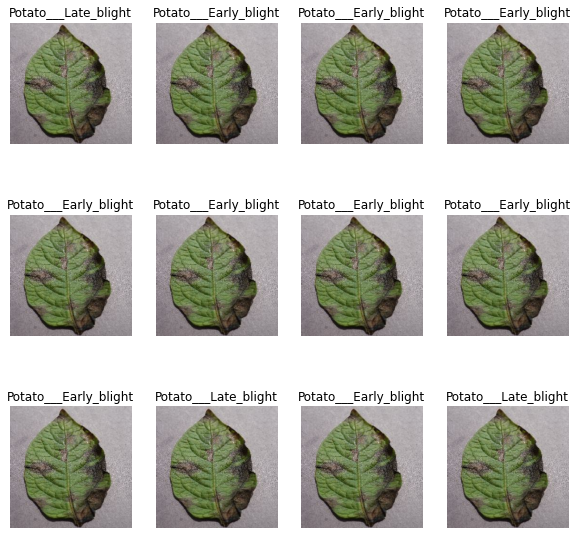

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [8]:
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [9]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [10]:
len(train_ds)

54

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [24]:
n_classes=3
input_shape=(batch_size,image_size,image_size,CHANNELS)

In [25]:
model=models.Sequential([
    resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),          
])
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [27]:
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"]
)


In [28]:
history=model.fit(
train_ds,
epochs=EPOCHS,
batch_size=batch_size,
verbose=1,
validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 131s 2s/step - loss: 0.8699 - accuracy: 0.5214 - val_loss: 0.6516 - val_accuracy: 0.7188
Epoch 2/50
54/54 [==============================] - 87s 2s/step - loss: 0.5755 - accuracy: 0.7436 - val_loss: 0.4209 - val_accuracy: 0.8594
Epoch 3/50
54/54 [==============================] - 82s 2s/step - loss: 0.4238 - accuracy: 0.8275 - val_loss: 0.3580 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 79s 1s/step - loss: 0.3732 - accuracy: 0.8455 - val_loss: 0.2729 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 1189s 22s/step - loss: 0.2862 - accuracy: 0.8843 - val_loss: 0.2309 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 116s 2s/step - loss: 0.2280 - accuracy: 0.9080 - val_loss: 0.1888 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 112s 2s/step - loss: 0.2229 - accuracy: 0.9109 - val_loss: 0.1844 - val_accuracy: 0.9219
Epoch 8/50
54/

In [29]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 538ms/step - loss: 0.0756 - accuracy: 0.9766


In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation accuracy')

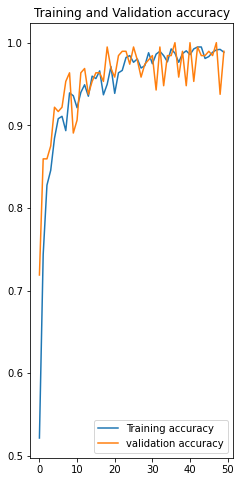

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training accuracy")
plt.plot(range(EPOCHS),val_acc,label="validation accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation accuracy")

first image to predict
first image's actual label Potato___Late_blight
1/1 [==============================] - 1s 822ms/step
Predicted label Potato___Late_blight


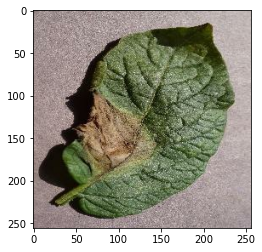

In [41]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0]
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label",class_names[first_label])
    batch_prediction=model.predict(image_batch)
    print("Predicted label",class_names[np.argmax(batch_prediction[0])])

In [42]:
#writing a function for prediction
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #creating a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 92ms/step


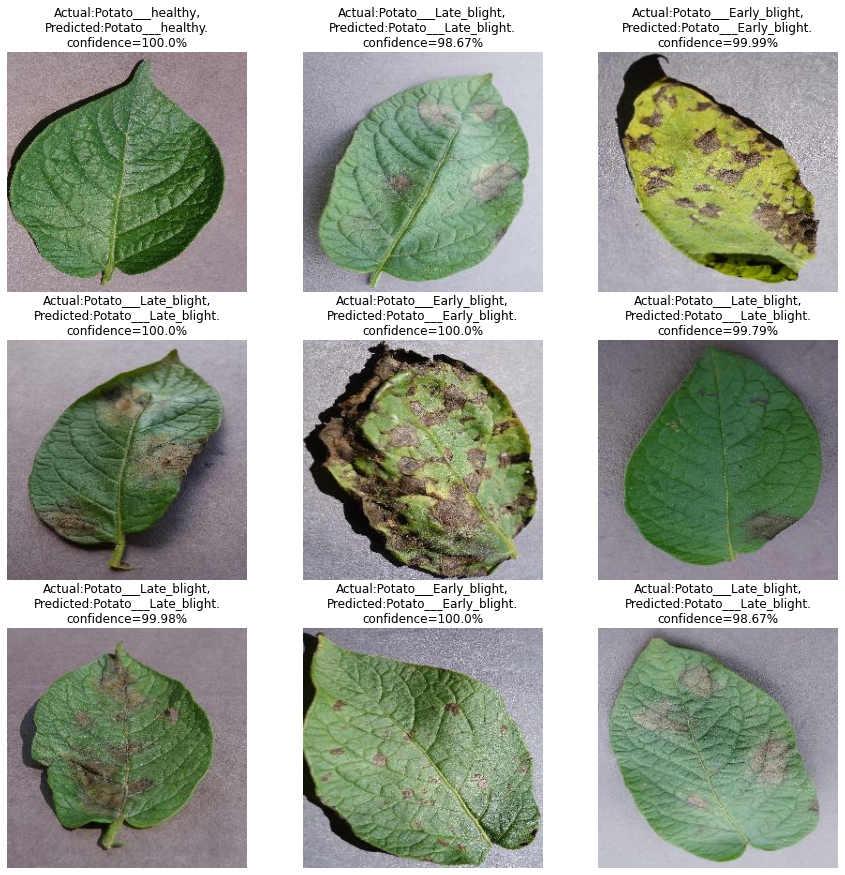

In [45]:
plt.figure(figsize=(15,15))
for images,label in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[label[i]]
        plt.title(f"Actual:{actual_class},\nPredicted:{predicted_class}.\nconfidence={confidence}%")
        plt.axis("off")
        

In [48]:
import os
model_version=max([int(i) for i in os.listdir("../model")+[0]])+1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/2\assets


INFO:tensorflow:Assets written to: ../model/2\assets
